In [ ]:
! pip install jcopdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16924 sha256=60c3b8359edeba6f1eba8e167f3752ea3f50c74d5860c694aea4fcbf2081843f
  Stored in directory: /root/.cache/pip/wheels/e5/78/9d/931694cba38491e16f1a94719193211fd12a7307570d9bb562
Successfully built jcopdl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.0 MB/s 


In [ ]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/flowers.rar")

patool: Extracting /content/drive/MyDrive/flowers.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/flowers.rar
patool:     with cwd='./Unpack_rfpnjy3e'
patool: ... /content/drive/MyDrive/flowers.rar extracted to `flowers'.


'flowers'

In [ ]:
import jcopdl
jcopdl.__version__

'1.1.9'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset & Dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [ ]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder("/content/flowers/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("/content/flowers/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# cek kelas
label2cat = train_set.classes
label2cat

['Bouganvillea',
 'Daisies',
 'Gardenias',
 'Gardenroses',
 'Hibiscus',
 'Hydrangeas',
 'Lilies',
 'Orchids',
 'Peonies',
 'Tulip']

## Arsitektur & Config

### Cara pakai Pretrained-Model

In [ ]:
from torchvision.models import densenet121

In [ ]:
mnet = densenet121(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

### Freeze Model (Bekuin Model)

In [ ]:
for param in mnet.parameters():
    param.requires_grad = False

In [ ]:
mnet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
mnet.classifier = nn.Sequential(
    nn.Linear(1024, 10, bias=True),
    nn.LogSoftmax()
)

In [ ]:
class CustomDensenet121(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = densenet121(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1024, output_size),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.mnet(x)

    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in mnet.parameters():
            param.requires_grad = True

In [ ]:
config = set_config ({
    "output_size" : len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size
    "label2cat": label2cat
})

## Pase 1 : Adaptasi (Learning Rate Standard + Patience Kecil)

In [ ]:
model = CustomDensenet121(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model_flowers")

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 2.0637 | Test_cost  = 1.7941 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 1.4281 | Test_cost  = 1.2832 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.9861 | Test_cost  = 0.9793 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.7394 | Test_cost  = 0.7731 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5855 | Test_cost  = 0.6722 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4739 | Test_cost  = 0.5632 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4108 | Test_cost  = 0.5095 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3664 | Test_cost  = 0.4605 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3207 | Test_cost  = 0.4423 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.2901 | Test_cost  = 0.3935 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.2501 | Test_cost  = 0.3795 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2389 | Test_cost  = 0.3433 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2173 | Test_cost  = 0.3376 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2018 | Test_cost  = 0.3227 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1858 | Test_cost  = 0.3062 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c786c0b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c786c0b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1790 | Test_cost  = 0.2943 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1689 | Test_cost  = 0.2868 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1531 | Test_cost  = 0.2835 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1483 | Test_cost  = 0.2699 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.1417 | Test_cost  = 0.2574 | 


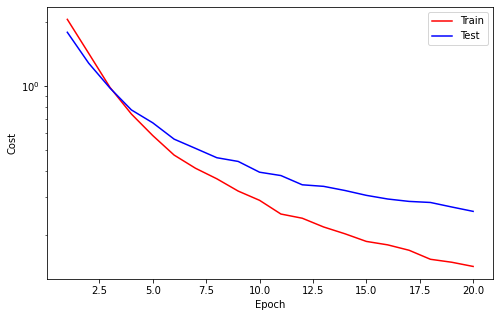

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.1325 | Test_cost  = 0.2512 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.1207 | Test_cost  = 0.2564 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2512


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.1276 | Test_cost  = 0.2472 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.1190 | Test_cost  = 0.2355 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c786c0b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c786c0b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.1049 | Test_cost  = 0.2417 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2355


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.1061 | Test_cost  = 0.2352 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0965 | Test_cost  = 0.2227 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0892 | Test_cost  = 0.2197 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0935 | Test_cost  = 0.2346 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2197


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0955 | Test_cost  = 0.2144 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0881 | Test_cost  = 0.2210 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2144


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c786c0b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c786c0b90>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__

      File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child processif w.is_alive():  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    
  File "/usr/lib/pytho

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0881 | Test_cost  = 0.2101 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0799 | Test_cost  = 0.2186 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2101


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0794 | Test_cost  = 0.2158 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2101
==> Execute Early Stopping at epoch: 34 | Best test_cost: 0.2101
==> Best model is saved at model_flowers


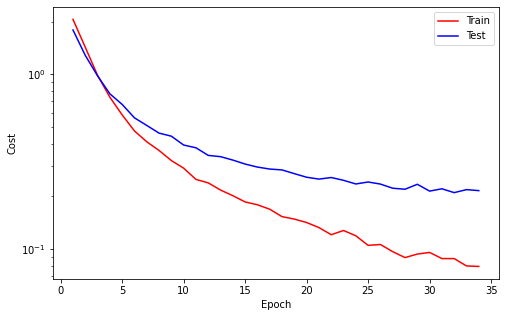

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Pase 2 : Fine-Tuning (learning rate dikecilin, patience ditambah)

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0767 | Test_cost  = 0.2092 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0756 | Test_cost  = 0.2054 | 


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0770 | Test_cost  = 0.2081 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2054


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0759 | Test_cost  = 0.2097 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2054


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0820 | Test_cost  = 0.2090 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2054


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0803 | Test_cost  = 0.2108 | 


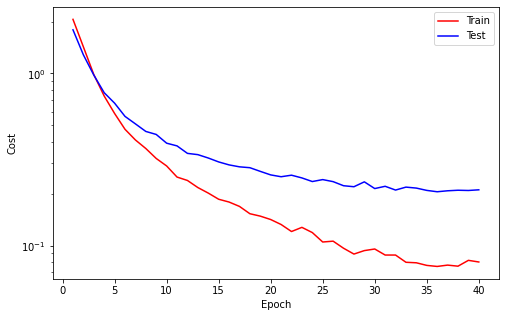

==> EarlyStop patience =  4 | Best test_cost: 0.2054


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0812 | Test_cost  = 0.2113 | 
==> EarlyStop patience =  5 | Best test_cost: 0.2054
==> Execute Early Stopping at epoch: 41 | Best test_cost: 0.2054
==> Best model is saved at model_flowers


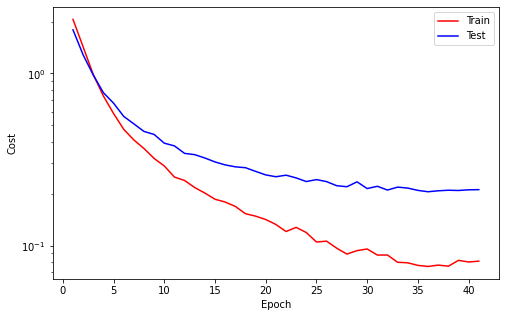

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Prediksi

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
        model.eval()
        output = model(feature)
        preds = output.argmax(1)
[label2cat [pred] for pred in preds]

['Gardenias',
 'Gardenias',
 'Lilies',
 'Daisies',
 'Bouganvillea',
 'Hydrangeas',
 'Lilies',
 'Hibiscus',
 'Hydrangeas',
 'Hibiscus',
 'Gardenias',
 'Orchids',
 'Bouganvillea',
 'Hydrangeas',
 'Peonies',
 'Bouganvillea',
 'Hibiscus',
 'Peonies',
 'Hibiscus',
 'Lilies',
 'Hydrangeas',
 'Orchids',
 'Gardenroses',
 'Tulip',
 'Orchids',
 'Gardenroses',
 'Hibiscus',
 'Gardenroses',
 'Hibiscus',
 'Tulip',
 'Hibiscus',
 'Orchids',
 'Lilies',
 'Gardenroses',
 'Gardenroses',
 'Lilies',
 'Lilies',
 'Tulip',
 'Orchids',
 'Gardenroses',
 'Daisies',
 'Lilies',
 'Hydrangeas',
 'Peonies',
 'Orchids',
 'Peonies',
 'Hydrangeas',
 'Bouganvillea',
 'Orchids',
 'Daisies',
 'Daisies',
 'Bouganvillea',
 'Bouganvillea',
 'Gardenias',
 'Gardenroses',
 'Hydrangeas',
 'Lilies',
 'Daisies',
 'Gardenias',
 'Daisies',
 'Orchids',
 'Gardenroses',
 'Peonies',
 'Hydrangeas']

## Sanity Check (Visualisasi)

In [ ]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

In [ ]:
import matplotlib.pyplot as plt

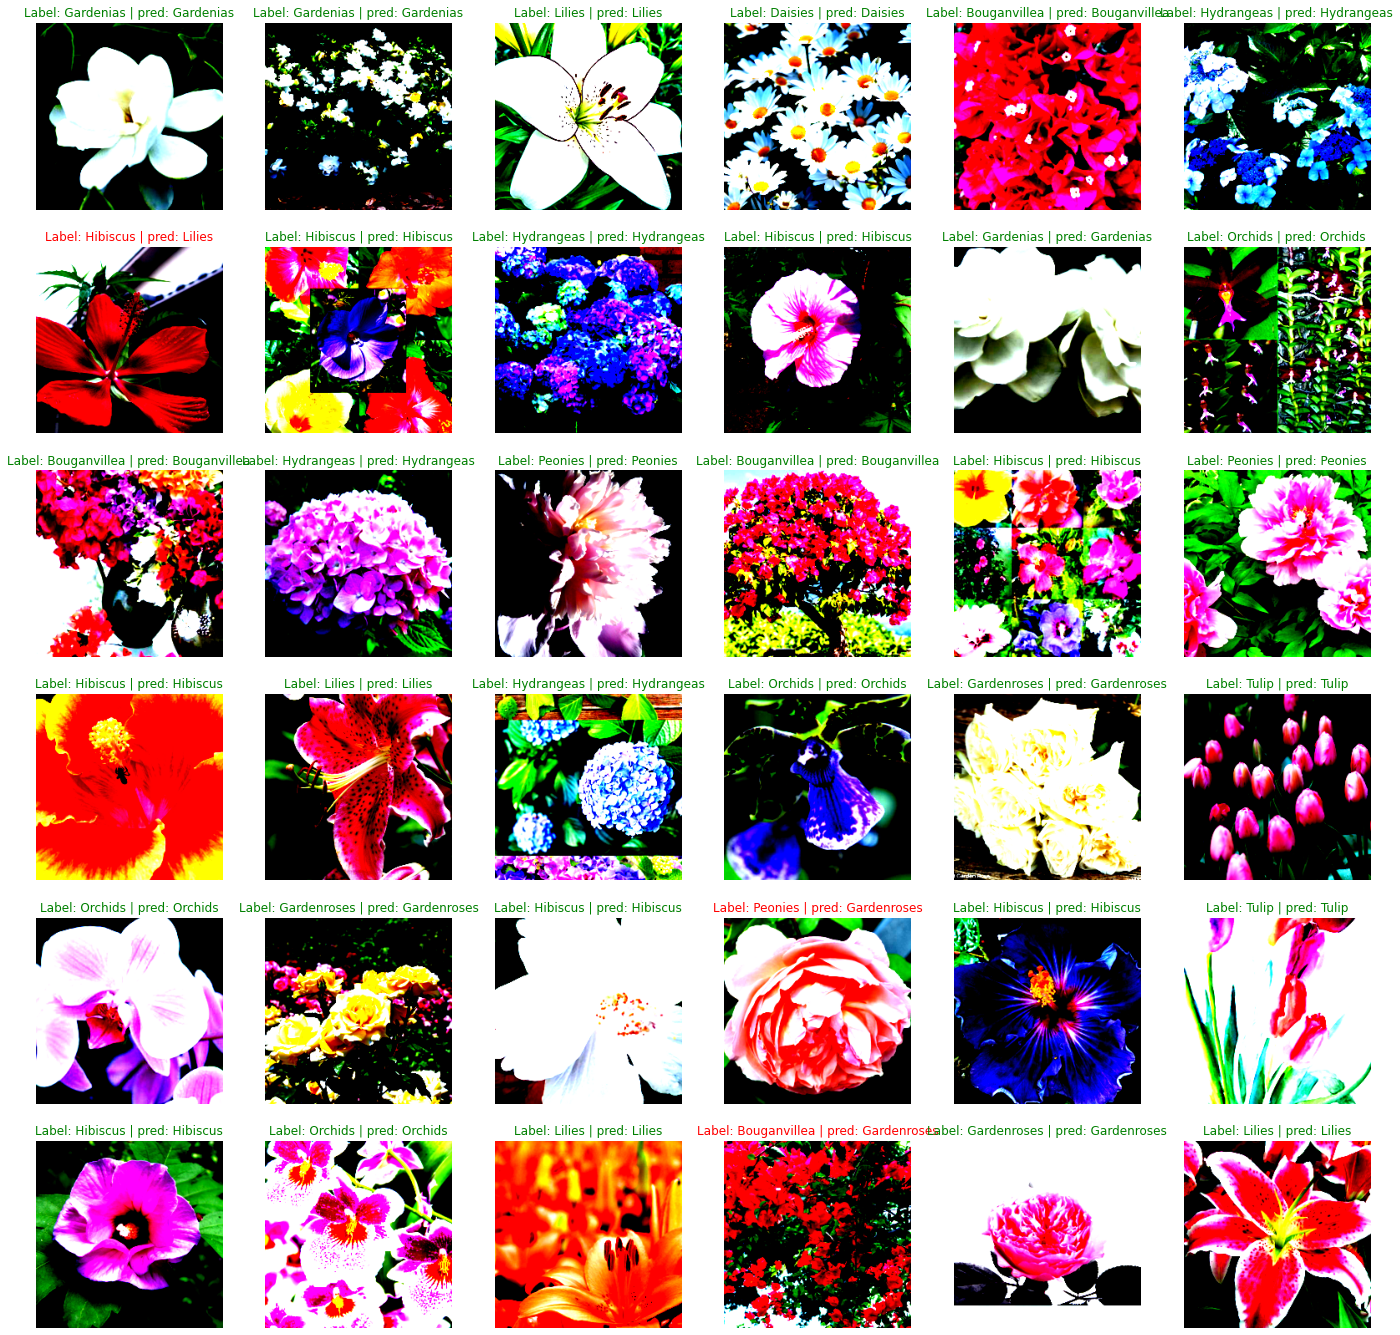

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu(), cmap='gray')
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | pred: {pred}", fontdict=font);
    ax.axis("off");

### Save Model

In [ ]:
! zip -r model_flowers.zip /content/model_flowers

  adding: content/model_flowers/ (stored 0%)
  adding: content/model_flowers/configs.pth (deflated 51%)
  adding: content/model_flowers/logs.pth (deflated 23%)
  adding: content/model_flowers/weights_best.pth (deflated 7%)
